In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]
graph.add_edges(graph.edges()[1], graph.edges()[0])

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_graphsage_linkpred_33_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fea2ba99f00> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(81485)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

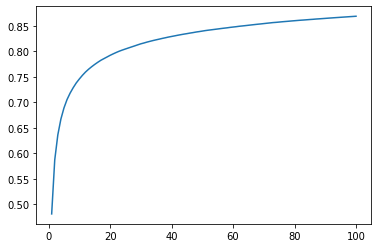

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.4812, 0.5870, 0.6360, 0.6670, 0.6888, 0.7053, 0.7179, 0.7285, 0.7379,
        0.7456, 0.7528, 0.7592, 0.7647, 0.7696, 0.7741, 0.7783, 0.7823, 0.7855,
        0.7887, 0.7919, 0.7948, 0.7976, 0.8001, 0.8023, 0.8044, 0.8064, 0.8085,
        0.8104, 0.8125, 0.8145, 0.8161, 0.8179, 0.8194, 0.8210, 0.8224, 0.8237,
        0.8251, 0.8264, 0.8278, 0.8289, 0.8301, 0.8313, 0.8324, 0.8335, 0.8345,
        0.8356, 0.8365, 0.8376, 0.8385, 0.8395, 0.8405, 0.8413, 0.8420, 0.8428,
        0.8436, 0.8444, 0.8451, 0.8458, 0.8467, 0.8474, 0.8481, 0.8489, 0.8495,
        0.8502, 0.8509, 0.8516, 0.8522, 0.8529, 0.8535, 0.8542, 0.8548, 0.8555,
        0.8561, 0.8566, 0.8572, 0.8577, 0.8582, 0.8587, 0.8593, 0.8598, 0.8603,
        0.8608, 0.8612, 0.8617, 0.8621, 0.8626, 0.8631, 0.8635, 0.8639, 0.8644,
        0.8648, 0.8652, 0.8657, 0.8661, 0.8665, 0.8669, 0.8673, 0.8677, 0.8681,
        0.8686])

In [18]:
percentages.max()

tensor(0.8686)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.66812328, 0.64992943, 0.63750298, 0.62773779, 0.61961699,
       0.61265794, 0.60679551, 0.60157934, 0.59676383, 0.59277738,
       0.5890707 , 0.58557779, 0.58241285, 0.57954397, 0.57681432,
       0.57416457, 0.57186407, 0.56962824, 0.56761192, 0.56562804,
       0.56371501, 0.5619536 , 0.56023573, 0.55859976, 0.5571041 ,
       0.55562879, 0.55418774, 0.55286755, 0.5515478 , 0.55025934,
       0.54906962, 0.54788045, 0.54673865, 0.54568382, 0.5446103 ,
       0.54360184, 0.54260193, 0.54165603, 0.54068961, 0.53974404,
       0.53883754, 0.5379863 , 0.53713881, 0.53633266, 0.53550644,
       0.53476043, 0.53401676, 0.53328612, 0.5325818 , 0.53183432,
       0.53111396, 0.53042494, 0.52974553, 0.52907642, 0.5284296 ,
       0.52780061, 0.52717049, 0.52656596, 0.52597892, 0.5253832 ,
       0.52478436, 0.52422455, 0.5236468 , 0.52308757, 0.52255064,
       0.52198425, 0.52145927, 0.52094739, 0.52043914, 0.51994954,
       0.51944686, 0.51895331, 0.51847434, 0.51799059, 0.51752

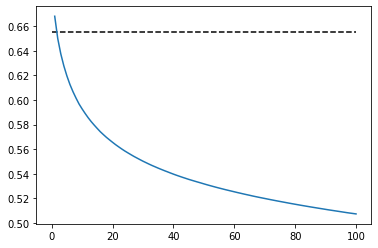

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fe9f4aa7f00> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(97304)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.7951441145887657

In [37]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [38]:
indices

array([[     0,  30038, 140574, ...,  15365, 159669,  30293],
       [     1, 154949, 100594, ...,  27363, 146071,  82905],
       [     2,  21962, 123185, ..., 123972,   3232,  69011],
       ...,
       [169340, 107677,  61320, ...,  45927, 144777,  90430],
       [169341, 103121,  34306, ...,   7162,  81875, 138717],
       [169342, 156784,  90378, ...,  13522, 129631,  11239]])

In [39]:
sum(emb_norm[0] * emb_norm[411])

0.5902882291775313

In [40]:
distances

array([[0.99999994, 0.9839313 , 0.97480965, ..., 0.76914084, 0.7684637 ,
        0.767968  ],
       [0.99999994, 0.9904086 , 0.86433184, ..., 0.61304396, 0.61195445,
        0.6116012 ],
       [0.9999997 , 0.98403645, 0.98294115, ..., 0.91678196, 0.9164976 ,
        0.9162849 ],
       ...,
       [1.0000001 , 0.9411004 , 0.9352514 , ..., 0.8052049 , 0.8027781 ,
        0.8027362 ],
       [1.        , 0.9801512 , 0.9735405 , ..., 0.9351215 , 0.93456787,
        0.9344402 ],
       [1.0000001 , 0.83980805, 0.83902407, ..., 0.68769646, 0.6870604 ,
        0.6866459 ]], dtype=float32)

In [41]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [42]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

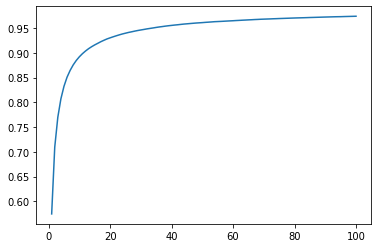

In [43]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [44]:
percentages

tensor([0.5746, 0.7095, 0.7698, 0.8069, 0.8322, 0.8506, 0.8643, 0.8754, 0.8844,
        0.8919, 0.8981, 0.9035, 0.9082, 0.9122, 0.9159, 0.9191, 0.9224, 0.9252,
        0.9279, 0.9301, 0.9322, 0.9343, 0.9362, 0.9380, 0.9395, 0.9410, 0.9423,
        0.9437, 0.9449, 0.9460, 0.9471, 0.9482, 0.9492, 0.9501, 0.9512, 0.9521,
        0.9529, 0.9538, 0.9546, 0.9553, 0.9560, 0.9566, 0.9573, 0.9579, 0.9585,
        0.9590, 0.9595, 0.9601, 0.9605, 0.9609, 0.9614, 0.9618, 0.9623, 0.9628,
        0.9630, 0.9633, 0.9637, 0.9640, 0.9644, 0.9647, 0.9651, 0.9654, 0.9657,
        0.9661, 0.9664, 0.9667, 0.9671, 0.9673, 0.9677, 0.9679, 0.9681, 0.9683,
        0.9686, 0.9688, 0.9691, 0.9693, 0.9695, 0.9698, 0.9700, 0.9702, 0.9704,
        0.9706, 0.9708, 0.9710, 0.9712, 0.9714, 0.9716, 0.9717, 0.9719, 0.9721,
        0.9723, 0.9725, 0.9727, 0.9728, 0.9729, 0.9731, 0.9733, 0.9734, 0.9736,
        0.9737])

### Percentage of same class neighbors by neighborhood size

In [45]:
ind_labels = label_transform(indices)

In [46]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [47]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [48]:
perc_same_class = n_same_class / n_total

In [49]:
perc_same_class

array([0.68087845, 0.66441187, 0.65263794, 0.64332302, 0.63539207,
       0.62895032, 0.62319502, 0.61795734, 0.61353125, 0.60954453,
       0.60590528, 0.60269443, 0.59965232, 0.59695369, 0.59435032,
       0.591979  , 0.58982448, 0.58766527, 0.58555402, 0.58361107,
       0.58183208, 0.58019871, 0.57856155, 0.5769988 , 0.57552919,
       0.57414537, 0.57282185, 0.57151968, 0.57034458, 0.56916967,
       0.56801704, 0.56686411, 0.56584207, 0.56486365, 0.56384194,
       0.56285648, 0.56190514, 0.56098678, 0.56006842, 0.5591948 ,
       0.55833974, 0.55753679, 0.5567672 , 0.55598213, 0.55527631,
       0.55449424, 0.55376216, 0.55307054, 0.55240873, 0.55172638,
       0.55110645, 0.55047153, 0.54984898, 0.54922652, 0.54864495,
       0.5480658 , 0.54747237, 0.54691875, 0.54637669, 0.54581963,
       0.54528441, 0.54476503, 0.5442344 , 0.54371804, 0.5432093 ,
       0.54271839, 0.54222971, 0.54173378, 0.541266  , 0.54077599,
       0.54029313, 0.53982737, 0.5393768 , 0.53893489, 0.53847

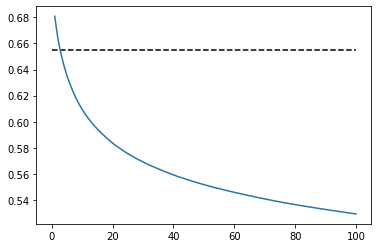

In [50]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Inner Product

In [51]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [52]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [53]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fe9f4a78c30> >

In [54]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [55]:
distances, indices = index_ip.search(embeddings, 2)

In [56]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(87370)

In [57]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [58]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

4.215521130448906

In [59]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [60]:
indices

array([[  1353, 166467,  67166, ...,  74060, 143149, 107556],
       [141692,      1, 154949, ...,  11254,  15571,  35374],
       [134600, 168209,  87117, ..., 114599, 122406,  84167],
       ...,
       [154342, 115359,  43354, ...,  45355,  48919,  43376],
       [ 61100, 123288, 140574, ..., 131488,  92101, 105878],
       [ 27824,  25265, 158981, ...,  47270, 143034,  73095]])

In [61]:
sum(embeddings[0] * embeddings[411])

7.4310422608978115

In [62]:
distances

array([[54.087673 , 52.325336 , 49.80829  , ..., 31.71435  , 31.695814 ,
        31.681074 ],
       [ 5.173541 ,  4.976526 ,  4.861054 , ...,  3.5589268,  3.5560825,
         3.5535047],
       [ 9.443337 ,  9.382454 ,  9.368136 , ...,  7.746041 ,  7.734716 ,
         7.7284365],
       ...,
       [10.874157 , 10.606646 , 10.527292 , ...,  8.076269 ,  8.063025 ,
         8.061408 ],
       [12.167973 , 12.066643 , 11.946959 , ...,  8.871861 ,  8.871466 ,
         8.850263 ],
       [ 5.659762 ,  5.2993073,  5.23302  , ...,  3.4555535,  3.4503806,
         3.436671 ]], dtype=float32)

In [63]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [64]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

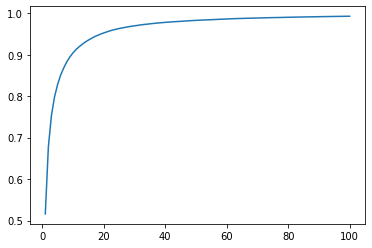

In [65]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [66]:
percentages

tensor([0.5159, 0.6777, 0.7535, 0.7980, 0.8280, 0.8509, 0.8681, 0.8830, 0.8945,
        0.9043, 0.9124, 0.9191, 0.9250, 0.9304, 0.9351, 0.9392, 0.9433, 0.9466,
        0.9497, 0.9524, 0.9549, 0.9575, 0.9596, 0.9614, 0.9631, 0.9645, 0.9659,
        0.9673, 0.9685, 0.9696, 0.9707, 0.9718, 0.9728, 0.9735, 0.9744, 0.9753,
        0.9760, 0.9767, 0.9773, 0.9780, 0.9785, 0.9790, 0.9795, 0.9800, 0.9804,
        0.9809, 0.9815, 0.9819, 0.9824, 0.9827, 0.9832, 0.9835, 0.9838, 0.9841,
        0.9844, 0.9848, 0.9852, 0.9855, 0.9858, 0.9861, 0.9864, 0.9867, 0.9870,
        0.9873, 0.9875, 0.9877, 0.9879, 0.9881, 0.9883, 0.9885, 0.9887, 0.9889,
        0.9891, 0.9893, 0.9894, 0.9896, 0.9897, 0.9899, 0.9901, 0.9902, 0.9904,
        0.9906, 0.9907, 0.9908, 0.9910, 0.9911, 0.9913, 0.9914, 0.9915, 0.9916,
        0.9918, 0.9919, 0.9920, 0.9922, 0.9923, 0.9923, 0.9924, 0.9926, 0.9927,
        0.9927])

### Percentage of same class neighbors by neighborhood size

In [67]:
ind_labels = label_transform(indices)

In [68]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [69]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [70]:
perc_same_class = n_same_class / n_total

In [71]:
perc_same_class

array([0.64478012, 0.63706206, 0.62995616, 0.62357021, 0.61803086,
       0.61310673, 0.60860671, 0.60412964, 0.60005695, 0.5965065 ,
       0.59327733, 0.59032949, 0.5877116 , 0.58516106, 0.58267894,
       0.580334  , 0.57816767, 0.57622039, 0.57435563, 0.57256367,
       0.57086392, 0.56926394, 0.56766855, 0.56619307, 0.56481602,
       0.56341113, 0.56210177, 0.56084692, 0.55965499, 0.5585252 ,
       0.55731363, 0.55619143, 0.5551376 , 0.55414698, 0.55313367,
       0.5521276 , 0.55121263, 0.55033773, 0.54943835, 0.54858586,
       0.54776372, 0.54693447, 0.54614626, 0.54536905, 0.54461825,
       0.54387545, 0.543188  , 0.54250951, 0.54179231, 0.54114986,
       0.54050423, 0.53986027, 0.53920663, 0.53856954, 0.5379525 ,
       0.53733315, 0.53672247, 0.53617602, 0.53558924, 0.53502891,
       0.53446333, 0.5339379 , 0.533397  , 0.53287042, 0.53233415,
       0.53181771, 0.53130937, 0.53082935, 0.53034066, 0.5298898 ,
       0.52943102, 0.52898694, 0.52853603, 0.52809594, 0.52764

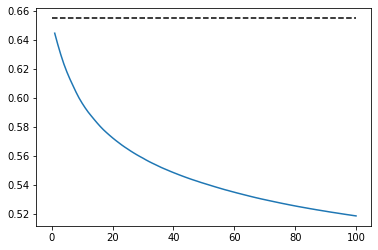

In [72]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [73]:
pca = PCA(n_components=2)

In [74]:
pca.fit(embeddings)

PCA(n_components=2)

In [75]:
emb_2d = pca.transform(embeddings)

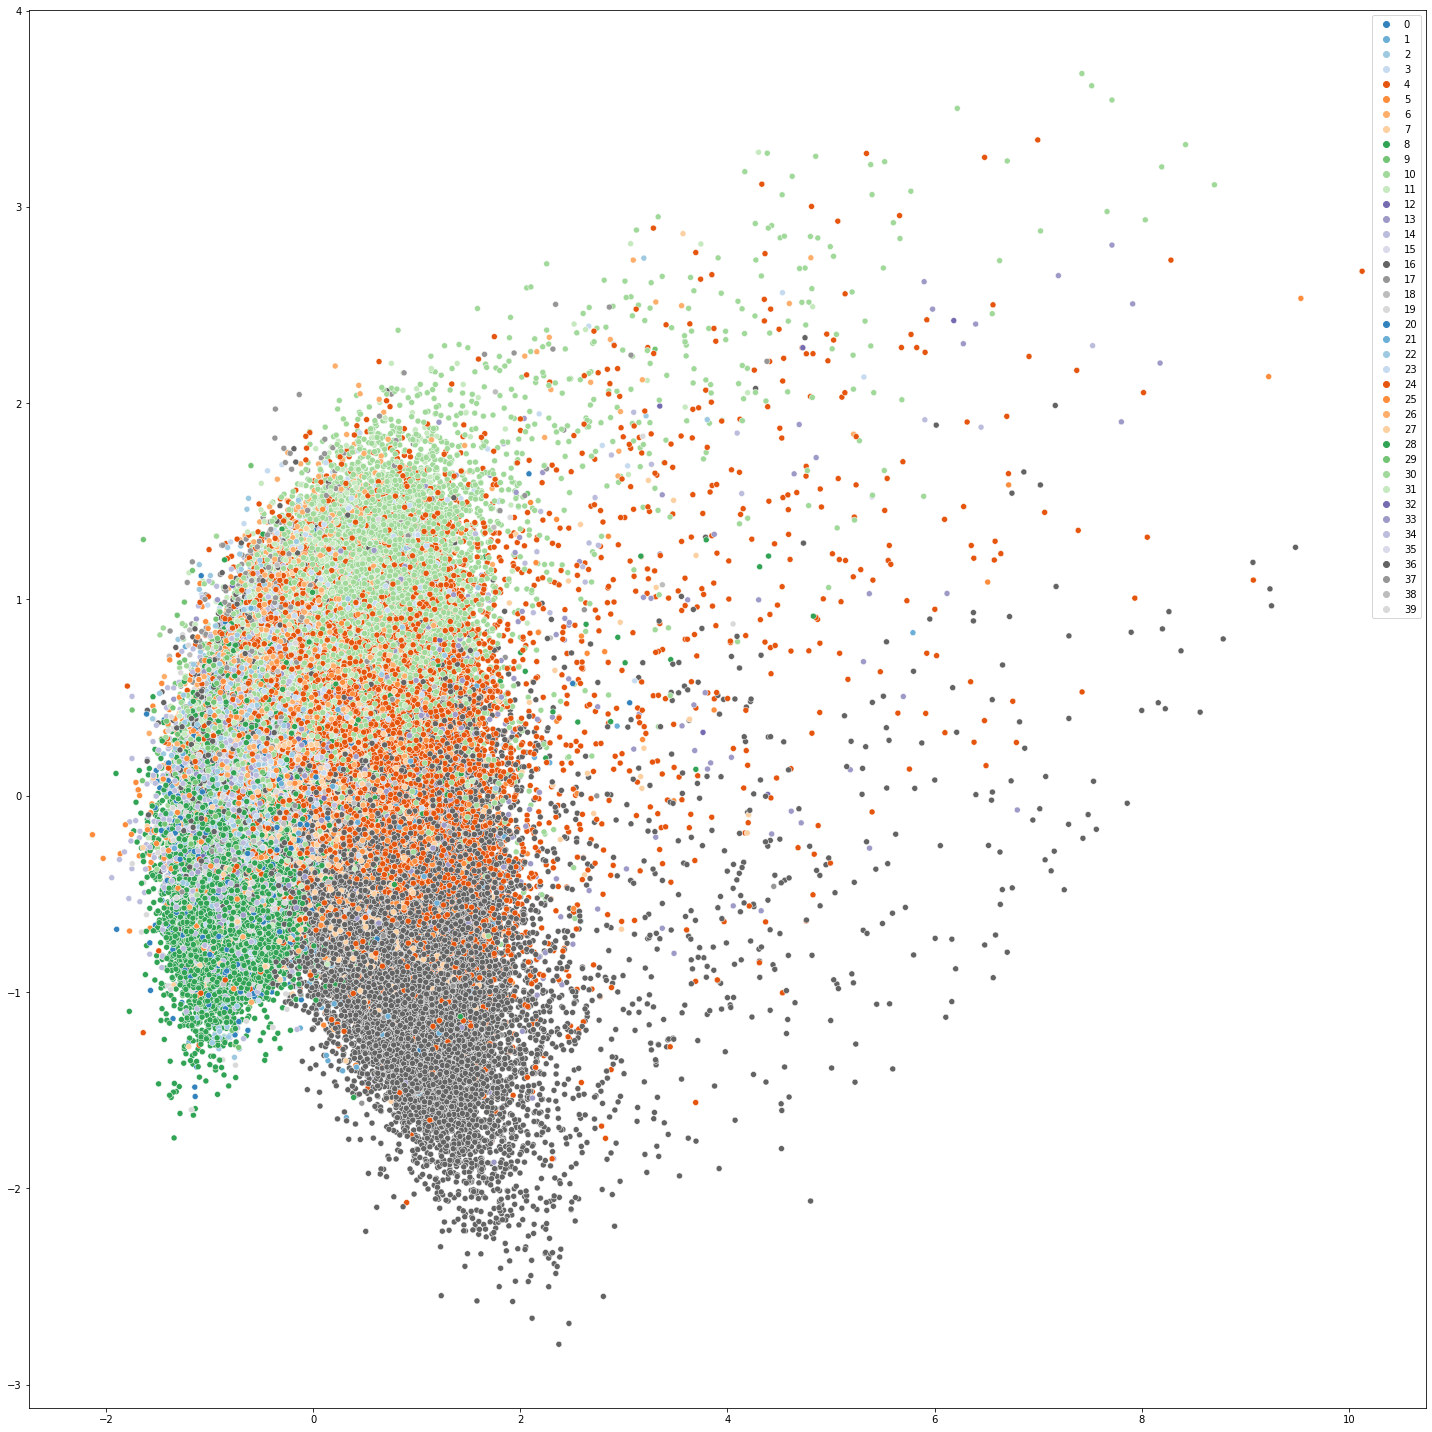

In [76]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [77]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

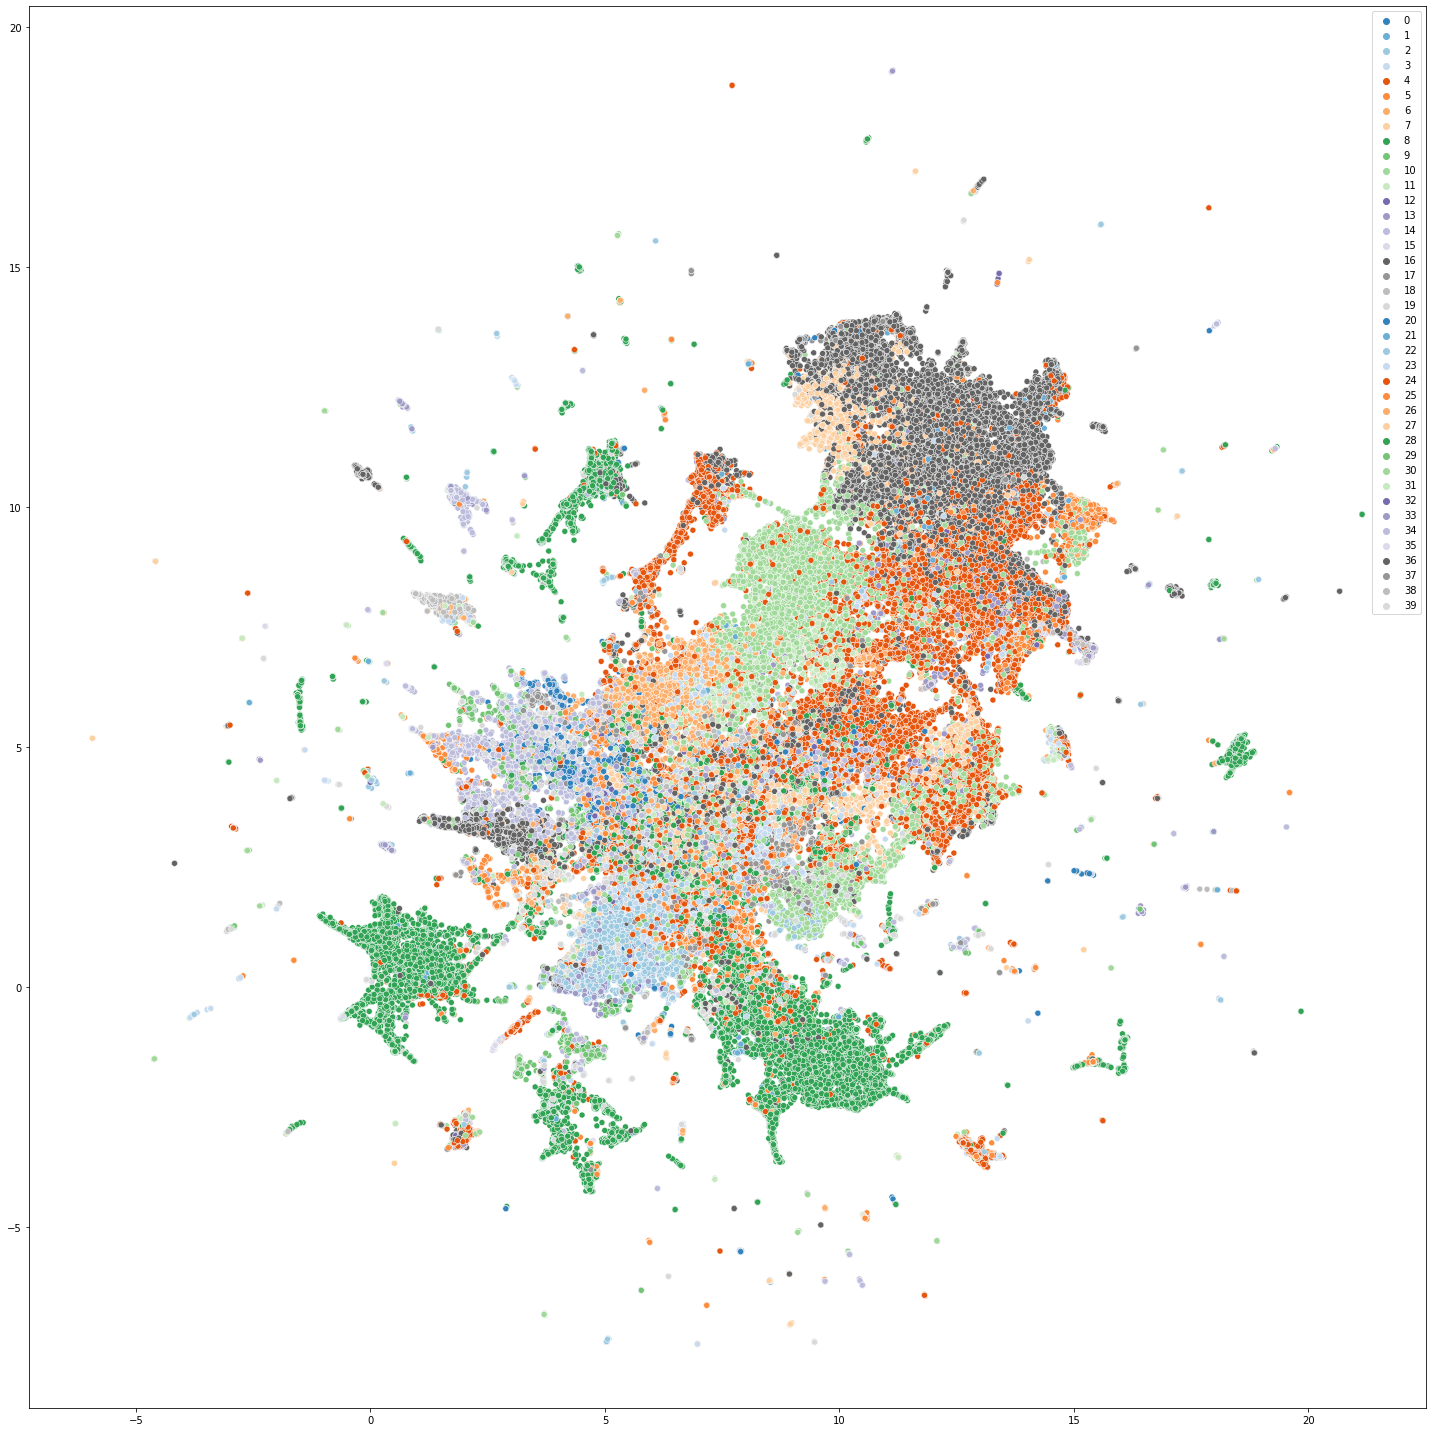

In [78]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [79]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

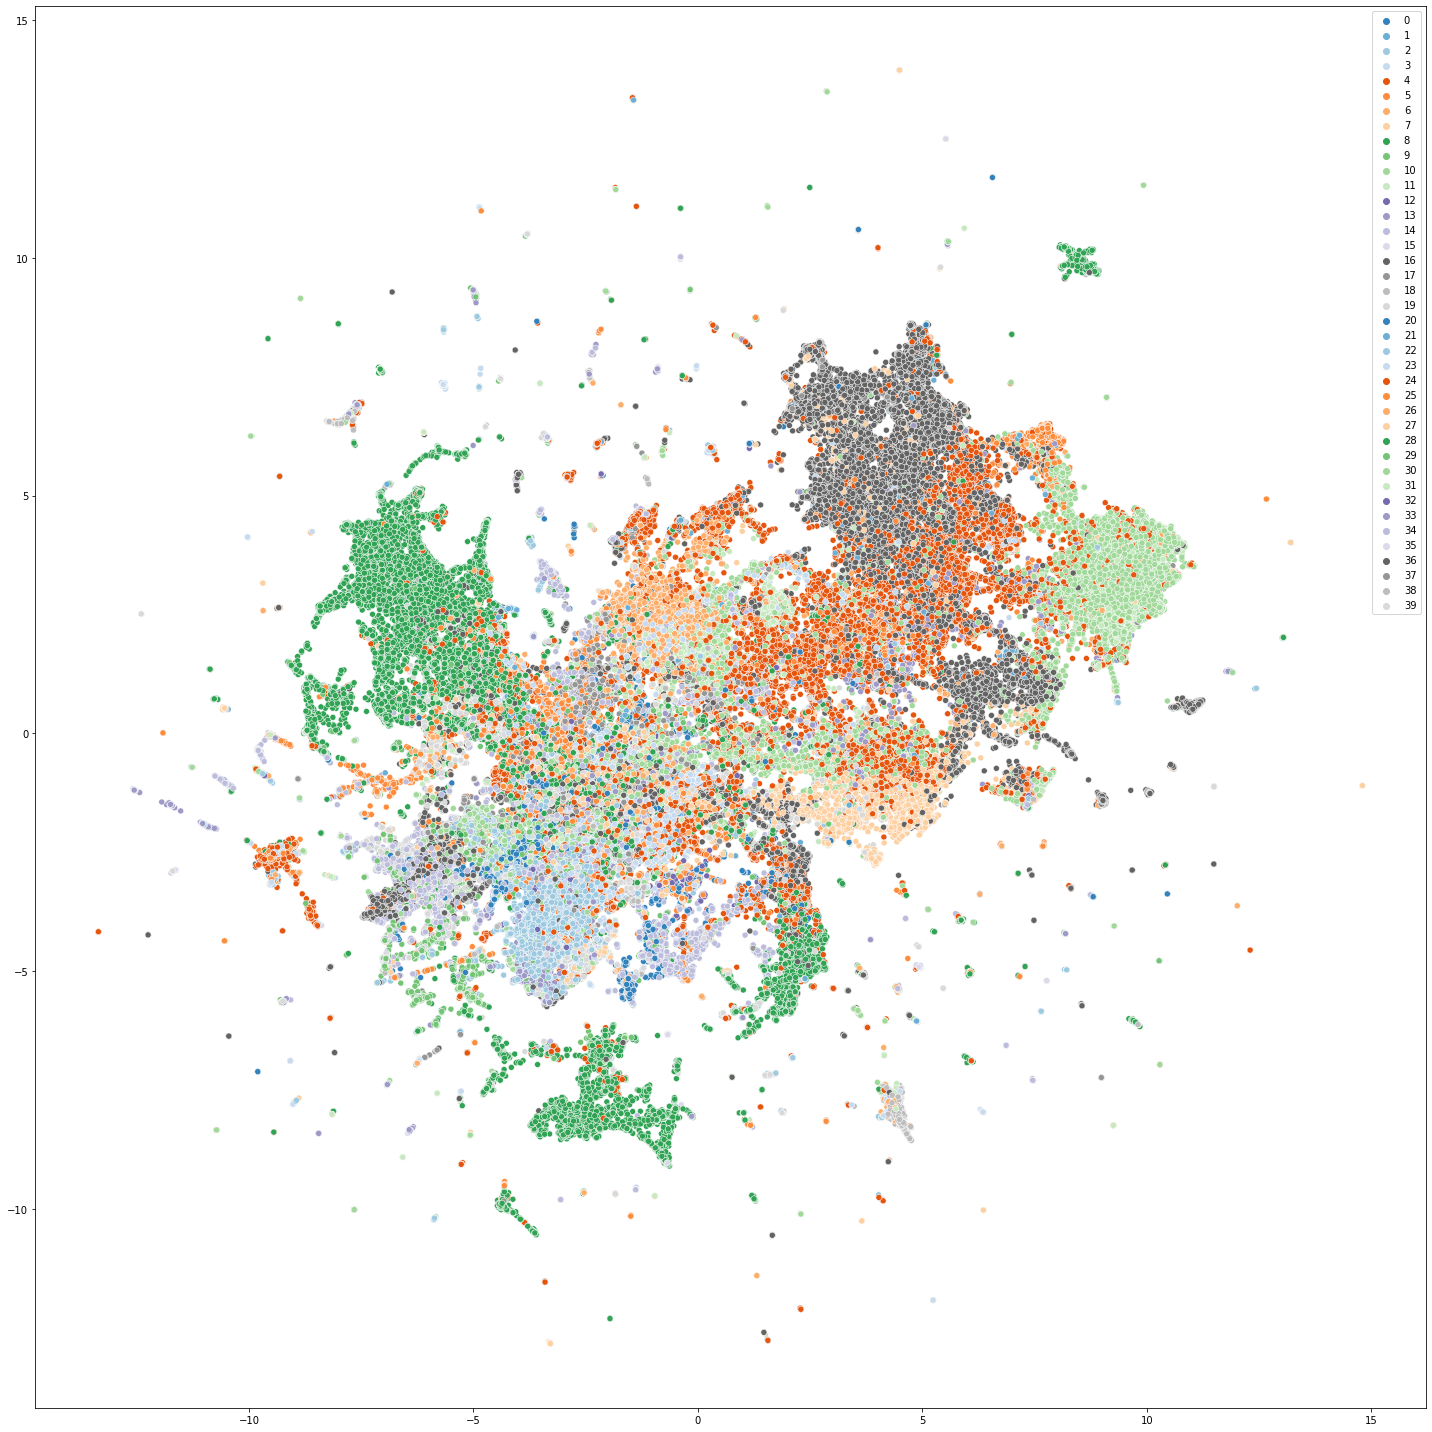

In [80]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()